In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import LabelEncoder

file_name = 'Food_Service_Establishment__Last_Inspection_20241123.csv'
df= pd.read_csv('Food_Service_Establishment__Last_Inspection_20241123.csv')

In [2]:
columns_to_drop = [
    'ADDRESS',  'FACILITY', 'CITY',
    'NYSDOH GAZETTEER (1980)', 'OPERATION NAME', 'PERMITTED  CORP. NAME',
    'PERM. OPERATOR LAST NAME','PERM. OPERATOR FIRST NAME','NYS HEALTH OPERATION ID',
    'INSPECTION COMMENTS', 'FOOD SERVICE FACILITY STATE', 'MUNICIPALITY',' LOCAL HEALTH DEPARTMENT','FACILITY ADDRESS'
]

df = df.drop(columns=columns_to_drop)
remaining_columns = df.columns.tolist()

df['VIOLATIONS'] = np.where(df['VIOLATIONS'] == 'No violations found.', 1, 0)
unique_values = df['VIOLATIONS'].unique()

date_columns = ["LAST INSPECTED", "PERMIT EXPIRATION DATE"]
for col in date_columns:
   df[col] = pd.to_datetime(df[col], errors="coerce")

label_encoder = LabelEncoder()
column_encoding = ['DESCRIPTION','INSPECTION TYPE','COUNTY','PERMITTED  (D/B/A)']

for col in column_encoding:
    df[col] = label_encoder.fit_transform(df[col])

df['LAST INSPECTED'] = pd.to_datetime(df['LAST INSPECTED'])
df.set_index('LAST INSPECTED', inplace=True)
df.sort_index(inplace=True)

df = df.dropna(subset=['TOTAL # CRITICAL VIOLATIONS', 'TOTAL #CRIT.  NOT CORRECTED ','TOTAL # NONCRITICAL VIOLATIONS'])

In [3]:
df

,VIOLATIONS,TOTAL # CRITICAL VIOLATIONS,TOTAL #CRIT. NOT CORRECTED,TOTAL # NONCRITICAL VIOLATIONS,DESCRIPTION,COUNTY,ZIP CODE,PERMIT EXPIRATION DATE,PERMITTED (D/B/A),INSPECTION TYPE,Location1
LAST INSPECTED,,,,,,,,,,,
2007-07-19,1,0.0,0.0,0.0,16,44,14870,2023-05-15,1687,0,"(42.222423, -77.136826)"
2007-09-19,0,2.0,0.0,0.0,4,52,10801,2012-04-30,1687,0,"(40.911135, -73.78051)"
2007-09-22,0,0.0,0.0,1.0,3,27,14105,NaT,1687,0,"(43.210675, -78.470443)"
2008-07-10,0,0.0,0.0,1.0,4,26,11566,2025-06-30,1687,0,"(40.657785, -73.546867)"
2008-08-05,0,0.0,0.0,1.0,19,20,13619,NaT,1687,0,"(43.980899, -75.610082)"
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15,0,1.0,0.0,2.0,3,40,12043,2024-12-31,1687,0,"(42.680472, -74.471885)"
2024-11-15,0,0.0,0.0,2.0,17,29,13203,2025-02-01,1687,1,"(43.063711, -76.125443)"
2024-11-15,0,0.0,0.0,2.0,3,13,12932,2025-07-31,1687,0,"(44.216424, -73.590576)"


In [14]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00


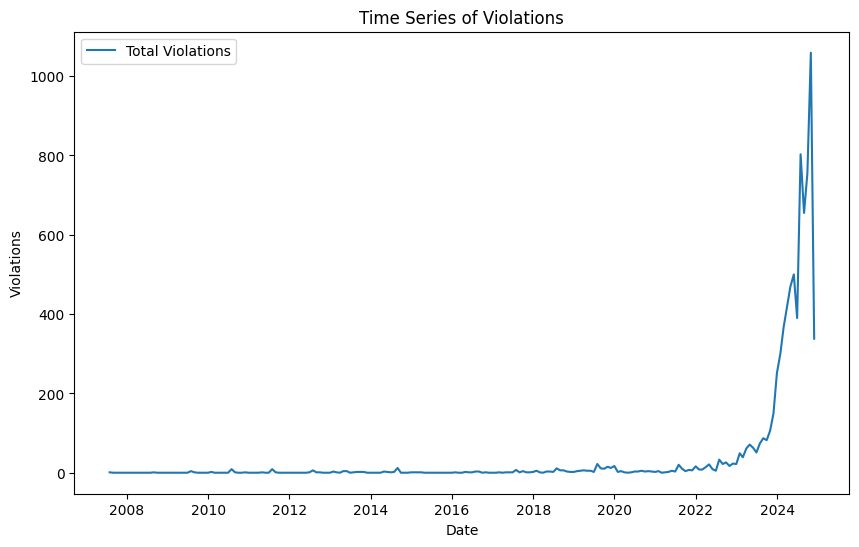

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

ts_data = df['VIOLATIONS'].resample('ME').sum()

plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Total Violations')
plt.title('Time Series of Violations')
plt.xlabel('Date')
plt.ylabel('Violations')
plt.legend()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("true")
    else:
        print("false")

adf_test(ts_data)

ADF Statistic: 3.775782186085844
p-value: 1.0
false


In [17]:
def find_differencing_order(ts_data, max_diff=20, significance_level=0.05):
    d = 0
    diff_data = ts_data.copy()

    for i in range(max_diff):
        adf_result = adfuller(diff_data.dropna())
        p_value = adf_result[1]

        print(f"ADF Test at differencing level {d}: p-value = {p_value}")

        if p_value <= significance_level:
            print(f"Stationarity achieved at differencing order d = {d}")
            return d, diff_data

        diff_data = diff_data.diff().dropna()
        d += 1

    return d, diff_data
d, stationary_data = find_differencing_order(ts_data)

ADF Test at differencing level 0: p-value = 1.0
ADF Test at differencing level 1: p-value = 0.6622636130995454
ADF Test at differencing level 2: p-value = 0.17049620272349653
ADF Test at differencing level 3: p-value = 8.439921002853255e-09
Stationarity achieved at differencing order d = 3


In [18]:
from pmdarima import auto_arima

auto_model = auto_arima(ts_data, seasonal=False, trace=True, stepwise=True)
print("Best ARIMA order:", auto_model.order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2133.499, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2325.893, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2253.268, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2275.589, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2324.025, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2255.797, Time=1.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2144.456, Time=3.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2125.723, Time=4.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2144.876, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2122.742, Time=0.92 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2146.507, Time=0.58 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2124.689, Time=1.03 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2124.966, Time=0.88 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : 

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

model = ARIMA(ts_data, order=(4, 1, 3))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             VIOLATIONS   No. Observations:                  209
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1044.866
Date:                Tue, 17 Dec 2024   AIC                           2105.731
Time:                        06:07:19   BIC                           2132.432
Sample:                    07-31-2007   HQIC                          2116.528
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0775      0.091      0.849      0.396      -0.102       0.257
ar.L2          0.7588      0.040     19.091      0.000       0.681       0.837
ar.L3          0.5033      0.045     11.202      0.0

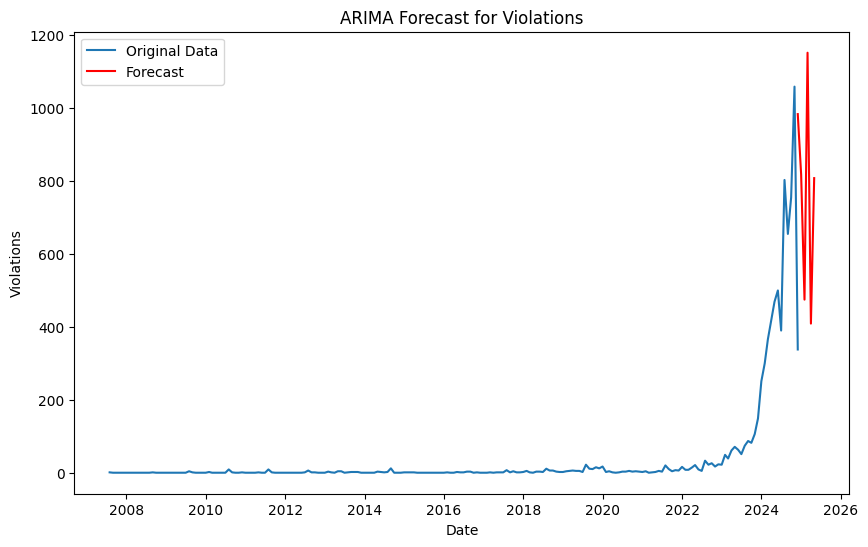

In [20]:
forecast_steps = 6
forecast = model_fit.forecast(steps=forecast_steps)

prediction_date=pd.date_range(ts_data.index[-1], periods=forecast_steps, freq='ME')

prediction_date = np.asarray(prediction_date)
forecast=np.asarray(forecast)


plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Original Data')
plt.plot(prediction_date,forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast for Violations')
plt.xlabel('Date')
plt.ylabel('Violations')
plt.legend()
plt.show()